# Fit RTs - AI and EA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
from scipy import integrate
from numba import jit

from psiam_utils import rho_A_t_arr_fn, rho_E_t_arr_fn, cum_A_t_arr_fn, cum_E_t_arr_fn, rho_A_t_fn, rho_E_t_fn
from scipy.integrate import quad
from psiam_utils import simulate_psiam

# Generate Data

In [2]:
V_A = 1; theta_A = 2; 
V_E = 0.5; theta_E = 1
Z_E = 0
t_stim = 0.3

N_sim = 10000
choices = np.zeros((N_sim, 1)); RTs = np.zeros((N_sim, 1)); is_act_resp = np.zeros((N_sim, 1))


def simulate_wrapper(V_A, theta_A, V_E, theta_E, Z_E, t_stim):
    return simulate_psiam(V_A, theta_A, V_E, theta_E, Z_E, t_stim)

results = Parallel(n_jobs=-1)(delayed(simulate_wrapper)(V_A, theta_A, V_E, theta_E, Z_E, t_stim) for _ in range(N_sim))

choices, RTs, is_act_resp = zip(*results)
choices = np.array(choices).reshape(-1, 1)
RTs = np.array(RTs).reshape(-1, 1)
is_act_resp = np.array(is_act_resp).reshape(-1, 1)

print(f'Num of act resp = {is_act_resp.sum()}/{N_sim}')
print(f'Number of aborts = {(RTs < t_stim).sum()}')

psiam_data = {'choices': choices, 'RTs': RTs, 'is_act_resp': is_act_resp, 'V_A': V_A, 'theta_A': theta_A, 'V_E': V_E, 'theta_E': theta_E, 't_stim': t_stim, 'Z_E': Z_E}


with open('psiam_data_5k_1.pkl', 'wb') as f:
    pickle.dump(psiam_data, f)

Num of act resp = 3052/10000
Number of aborts = 18


# Read data

In [3]:
with open('psiam_data_5k_1.pkl', 'rb') as f:
    psiam_data = pickle.load(f)


choices = psiam_data['choices']
RTs = psiam_data['RTs']
is_act_resp = psiam_data['is_act_resp']
V_A = psiam_data['V_A']
theta_A = psiam_data['theta_A']
V_E = psiam_data['V_E']
theta_E = psiam_data['theta_E']
Z_E = psiam_data['Z_E']
t_stim = psiam_data['t_stim']


indices_evid = np.where(is_act_resp == 0)[0]
RTs_evid = RTs[indices_evid]

indices_act = np.where(is_act_resp == 1)[0]
RTs_act = RTs[indices_act]


print(f"V_A: {V_A}")
print(f"theta_A: {theta_A}")
print(f"V_E: {V_E}")
print(f"theta_E: {theta_E}")
print(f"Num of AI process: {is_act_resp.sum()}/{len(is_act_resp)}")
print(f"t start is {t_stim}")

V_A: 1
theta_A: 2
V_E: 0.5
theta_E: 1
Num of AI process: 3052/10000
t start is 0.3


# Plotting both P and CDF of AI and EA
Not sensible because a fraction of EA responses are taken by EA, and fraction of AI responses are taken by EA

<Axes: >

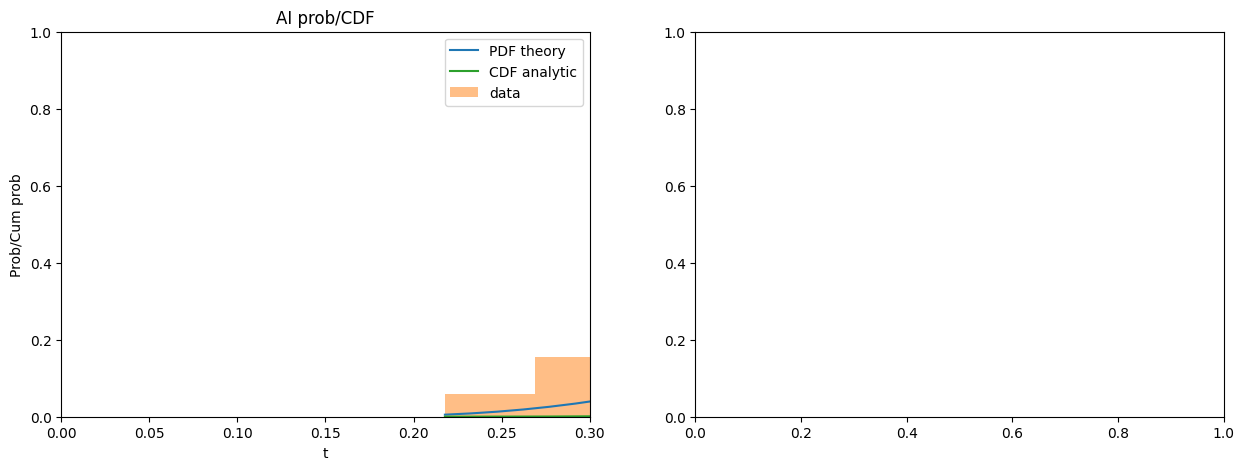

In [18]:
plt.figure(figsize=(15, 5))
# AI
RTs_act_flat = RTs_act.flatten()
t_pts = np.linspace(min(RTs_act_flat), 15, 1000)
# AI prob
norm_const, _ = quad(rho_A_t_fn, 0, np.inf, args=(V_A, theta_A))
rho_t_A_theory = rho_A_t_arr_fn(t_pts, V_A, theta_A)
rho_t_A_theory /= norm_const
plt.subplot(1,2,1)
plt.plot(t_pts, rho_t_A_theory);
# AI data
plt.hist(RTs_act_flat, bins=100, density=True, alpha=0.5);

# AI CDF
cum_A_t_theory = cum_A_t_arr_fn(t_pts, V_A, theta_A)
plt.plot(t_pts, cum_A_t_theory);
plt.ylim(0, 1);
plt.xlabel('t'); plt.ylabel('Prob/Cum prob');plt.title('AI prob/CDF');plt.legend(['PDF theory', 'CDF analytic', 'data']);
plt.xlim(0, 0.3)

# EA
plt.subplot(1,2,2)
# ---- TEMP ----
# with open('sample_rt.pkl', 'rb') as f:
#     RTs_evid_flat = pickle.load(f)

# V_E = 1.2; theta_E = 1
# --------------
min_val = 0.001

RTs_evid_flat = RTs_evid.flatten()

K_max = 50
t_pts = np.linspace(min_val, max(RTs_evid_flat), 1000)
rho_t_E_theory = rho_E_t_arr_fn(t_pts, V_E, theta_E, K_max)
# norm_const, _ = quad(rho_E_t_fn, min(RTs_evid_flat), np.inf, args=(V_E, theta_E, K_max))
# rho_t_E_theory /= norm_const

# Data
plt.hist(RTs_evid_flat, density=True, bins=100, alpha=0.5);
# Custom histogram
# Normalize the histogram
# hist_values, bin_edges = np.histogram(RTs_evid_flat, bins=t_pts, density=True)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# plt.bar(bin_centers, hist_values, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='data')



# EA PDF
plt.plot(t_pts, rho_t_E_theory);
# EA cdf
cum_E_t_theory = cum_E_t_arr_fn(t_pts, V_E, theta_E, K_max, min_val)
plt.plot(t_pts, cum_E_t_theory);
plt.xlabel('t'); plt.ylabel('Prob/Cum prob');plt.title('EA prob/CDF');plt.legend(['PDF theory', 'CDF - PDF numeric integ', 'data']);

# Fit all RTs

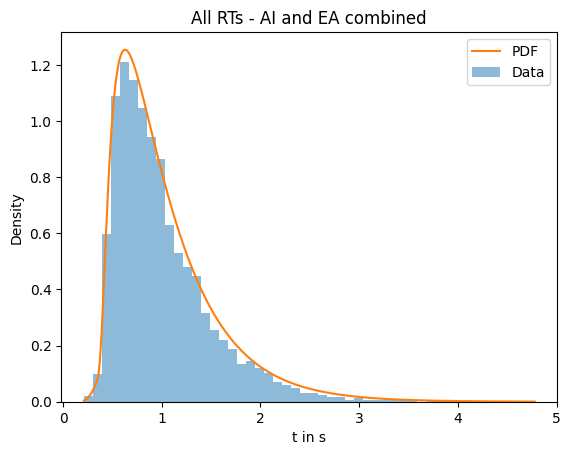

In [4]:
RTs_flat = RTs.flatten()
K_max = 50

# data
plt.hist(RTs_flat, density=True, bins=50, alpha=0.5);

# theory
t_pts = np.linspace(min(RTs_flat), max(RTs_flat), 1000)
P_A = rho_A_t_arr_fn(t_pts, V_A, theta_A).flatten()
C_E = cum_E_t_arr_fn(t_pts, V_E, theta_E, K_max, t_stim).flatten()

P_E = rho_E_t_arr_fn(t_pts, V_E, theta_E, K_max, t_stim).flatten()
C_A = cum_A_t_arr_fn(t_pts, V_A, theta_A).flatten()

p_theory  = (P_A)*(1 - C_E) + (P_E)*(1 - C_A)

plt.plot(t_pts, p_theory)
plt.xlabel('t in s'); plt.ylabel('Density'); plt.title('All RTs - AI and EA combined');
plt.legend(['PDF', 'Data']);

# Rough work for integration

In [5]:
K_max = 50
c, _ = quad(rho_E_t_fn, 0.2, 0.3, args=(V_E, theta_E, K_max, t_stim))
print(f'integ from 0.1 to 1 = {c}')

integ from 0.1 to 1 = 0.0
